## Demixed Principal Component Analysis (dPCA)

We revisit the toy example and the gist of dPCA algorithm introduced in [1]. The dataset here mimics neural recordings from 2 neurons responding to 3 stimuli (red,green,blue) over 5 time steps (connected dots) with 1 trial. The collection of all firing rates is defined as $2$ by $15(=5\times 3)$ matrix $\mathbf{X}$. The analysis starts from centering $\mathbf{X}$ for each neuron (or row).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import numpy as np
from numpy.linalg import *

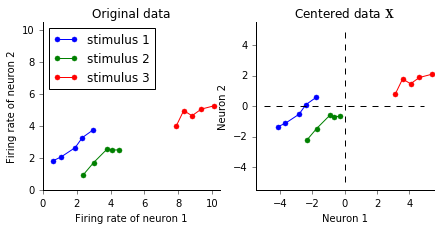

In [2]:
data = np.loadtxt('data1.out')
ns = 3 # the number of stimuli
nt = 5 # the number of time steps
X = (data - np.tile(data.mean(axis=0),(data.shape[0],1))).T

def plot_commonality():
    plt.plot(np.arange(-5,5,0.1),np.tile(0,100),'k--')
    plt.plot(np.tile(0,100),np.arange(-5,5,0.1),'k--')
    plt.xlim(-5.5,5.5); plt.ylim(-5.5,5.5)
def boxoff(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.tick_params(direction='out')

cv = ['b','g','r']
fig = plt.figure(figsize=(7,3))
ax = fig.add_subplot(121)
for ii in range(ns):
    plt.plot(data[nt*ii:nt*(ii+1),0],data[nt*ii:nt*(ii+1),1],'.-',color=cv[ii],ms=10,label='stimulus '+str(ii+1))
plt.xlim(0,10.5); plt.ylim(0,10.5); boxoff(ax)
plt.xlabel('Firing rate of neuron 1'); plt.ylabel('Firing rate of neuron 2');
plt.title('Original data')
plt.legend(loc=2)

ax = fig.add_subplot(122)
for ii in range(ns):
    plt.plot(X[0,nt*ii:nt*(ii+1)],X[1,nt*ii:nt*(ii+1)],'.-',color=cv[ii],ms=10)
plot_commonality(); boxoff(ax)
plt.xlabel('Neuron 1'); plt.ylabel('Neuron 2');
plt.title('Centered data $\mathbf{X}$');

### 1. Decomposition of Data

The first step of dPCA is to decompose $\mathbf{X}$ into uncorrelated terms like the one used in factorial ANOVA. Centered data matrix $\mathbf{X}$ can be decomposed into a set of averages over combinations of parameters through marginalization procedures. We have three parameters (stimulus $s$ out of $S$, trial $k$ out of $K$, and $T$ time points $t$), but there remain 3 terms only due to $K=1$:

\begin{eqnarray}
\mathbf{X} &=& \mathbf{X}_t + \mathbf{X}_s + \mathbf{X}_{ts} \color{gray}{+\mathbf{X}_{\textrm{noise}}}\\
&=& \sum_{\phi} \mathbf{X}_{\phi} \color{gray}{+\mathbf{X}_{\textrm{noise}}}
\end{eqnarray}

where $\mathbf{X}_t$ is the time-varying firing rate averaged over $s$, $\mathbf{X}_s$ is the stimulus-varying firing rate averaged over $t$, and $\mathbf{X}_{ts}$ is the residual stimulus-time interaction (averaged over the rest of parameters, which is none in this example). $\color{gray}{\mathbf{X}_{\textrm{noise}}}$ represents trial-to-trial noise/variability, but is gray-shaded due to the single trial of the data. Note that the marginalization is performed for each neuron and the size of all matrices is identical to each other: e.g. $\mathbf{X}_t$ is not $2\times 5$, but $2\times 15$ matrix with $2\times 5$ unique values replicated 3 times. (Note that the linear decomposition via marginalization ensures that $\mathbf{X}_{\phi}$s are uncorrelated; see details in [1]).

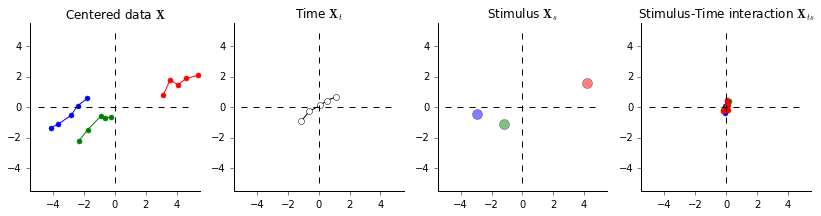

In [3]:
fig = plt.figure(figsize=(14,3))
ax = fig.add_subplot(141)
for ii in range(ns):
    plt.plot(X[0,nt*ii:nt*(ii+1)],X[1,nt*ii:nt*(ii+1)],'.-',color=cv[ii],ms=10)
plot_commonality(); boxoff(ax)
plt.title('Centered data $\mathbf{X}$');

Xt = np.array([np.reshape(X[0,:],(ns,nt)).mean(axis=0),
               np.reshape(X[1,:],(ns,nt)).mean(axis=0)])
ax = fig.add_subplot(142)
plt.plot(Xt[0,:],Xt[1,:],'ko-',ms=6,markerfacecolor='w')
plot_commonality(); boxoff(ax)
plt.title('Time $\mathbf{X}_t$');
# Replicate Xt to make the same size with X
Xt = np.tile(Xt,(1,ns))

Xs = np.array([np.reshape(X[0,:],(ns,nt)).mean(axis=1),
               np.reshape(X[1,:],(ns,nt)).mean(axis=1)])
ax = fig.add_subplot(143)
for ii in range(ns):
    plt.plot(Xs[0,ii],Xs[1,ii],'o',color=cv[ii],ms=10,alpha=0.5)
plot_commonality(); boxoff(ax)
plt.title('Stimulus $\mathbf{X}_s$');
# Replicate Xs to make the same size with X
Xs = [np.tile(Xs[:,ii],(nt,1)) for ii in range(ns)]
Xs = np.array(Xs)
Xs = Xs.reshape((ns*nt,2)).T

Xts = X - Xt - Xs
ax = fig.add_subplot(144)
for ii in range(ns):
    plt.plot(Xts[0,nt*ii:nt*(ii+1)],Xts[1,nt*ii:nt*(ii+1)],'.-',color=cv[ii],ms=10)
plot_commonality(); boxoff(ax)
plt.title('Stimulus-Time interaction $\mathbf{X}_{ts}$');

### 2. Loss Function of dPCA

Given the linear decomposition $\mathbf{X} = \sum_{\phi} \mathbf{X}_{\phi} \color{gray}{+\mathbf{X}_{\textrm{noise}}}$ and uncorrelated characteristic of $\mathbf{X}_{\phi}$, the loss function of dPCA is given by

\begin{eqnarray}
L &=& \sum_{\phi} L_{\phi}\\
&=& \sum_{\phi} \vert\vert \mathbf{X}_{\phi}-\mathbf{F}_{\phi}\mathbf{D}_{\phi}\mathbf{X} \vert\vert^2
\end{eqnarray}

where $\mathbf{F}_{\phi}$ and $\mathbf{D}_{\phi}$ are reduced-rank encoder and decoder matrices, which can be analytically solved.

This loss function penalizes the difference between the marginalized data $\mathbf{X}_{\phi}$ and the reconstructed data $\hat{\mathbf{X}}_{\phi} (=\mathbf{F}_{\phi}\mathbf{D}_{\phi}\mathbf{X})$, i.e., the full data projected with the decoders $\mathbf{D}_{\phi}$ onto a low-dimensional latent space and then reconstructed with the encoders $\mathbf{F}_{\phi}$. We should particularly notice that the full data $\mathbf{X}$ is compared with each of marginalized data $\mathbf{X}_{\phi}$ aiming to search for the best projections in every $\phi$-defined space. The objective of dPCA is thereby to minimize both <font color='red'>the non-explained variance in marginalization $\phi$</font> and <font color='blue'>the variance coming from all the other marginalizations and from trial-to-trial noise</font> $^{[1]}$.

\begin{eqnarray}
\newline
L_{\phi} = \vert\vert \mathbf{X}_{\phi}-\mathbf{F}_{\phi}\mathbf{D}_{\phi}\mathbf{X} \vert\vert^2
= \color{red}{\vert\vert \mathbf{X}_{\phi}-\mathbf{F}_{\phi}\mathbf{D}_{\phi}\mathbf{X}_{\phi} \vert\vert^2}
+ \color{blue}{\vert\vert \mathbf{F}_{\phi}\mathbf{D}_{\phi}(\mathbf{X}-\mathbf{X}_{\phi}) \vert\vert^2}
\end{eqnarray}


### 3. Algorithm of dPCA

We note that the loss function $L_{\phi}$ is of the general form $\vert\vert \mathbf{X}_{\phi}-\mathbf{AX} \vert\vert^2$, with $\mathbf{A} = \mathbf{F}_{\phi}\mathbf{D}_{\phi}$. For an arbitrary $N\times N$ matrix $\mathbf{A}$ (where $N$ is # of neurons), minimization of the loss function amounts to a classical regression problem with the well-known ordinary least squares (OLS) solution, $\mathbf{A}_{OLS} = \mathbf{X}_{\phi}\mathbf{X}^T(\mathbf{X}\mathbf{X}^T)^{-1}$. In our case, $\mathbf{A} = \mathbf{F}_{\phi}\mathbf{D}_{\phi}$ is an $N\times N$ matrix of rank $q$, which we will make explicit by writing $\mathbf{A}_q$. The dPCA loss function therefore amounts to a <font color='red'>linear regression problem</font> with an additional <font color='blue'>rank constraint on the matrix of regression coefficients</font>. This problem is known as reduced-rank regression (RRR) $^{[1]}$.

\begin{eqnarray}
\newline
\vert\vert \mathbf{X}_{\phi}-\mathbf{A}_q\mathbf{X} \vert\vert^2
= \color{red}{\vert\vert \mathbf{X}_{\phi}-\mathbf{A}_{OLS}\mathbf{X} \vert\vert^2}
+ \color{blue}{\vert\vert \mathbf{A}_{OLS}\mathbf{X}-\mathbf{A}_q\mathbf{X} \vert\vert^2}
\end{eqnarray}

Here are three steps to solve the RRR problem:
##### 1. Compute the OLS solution (to minimize <font color='red'>first</font> term) 
$\mathbf{A}_{OLS} = \mathbf{X}_{\phi}\mathbf{X}^T(\mathbf{X}\mathbf{X}^T)^{-1}$
##### 2. Perform PCA of $A_{OLS}\mathbf{X}$ and take the $q$ leading principal components to obtain the best low-rank approximation (or to minimize <font color='blue'>second</font> term)
$\mathbf{A}_q = \mathbf{U}_q\mathbf{U}_q^T\mathbf{A}_{OLS}$ where $\mathbf{U}_q$ is the $N\times q$ matrix of the $q$ leading principal directions (left singular vectors) of $\mathbf{A}_{OLS}\mathbf{X}$.
##### 3. Factorize theh matrix $\mathbf{A}_q$ into encoder and decoder matrices, $\mathbf{A}_q = \mathbf{F}_{\phi}\mathbf{D}_{\phi}$ by choosing
$\mathbf{F}_{\phi} = \mathbf{U}_q$ and $\mathbf{D}_{\phi} = \mathbf{U}_q^T\mathbf{A}_{OLS}$

### 4. dPCA on $\mathbf{X}_{\phi}$

Let's apply the dPCA method to each marginalized $\mathbf{X}_{\phi}$. We will start with $\mathbf{X}_t$ followed by $\mathbf{X}_s$.

(Note that $\mathbf{X}_s$ and $\mathbf{X}_{ts}$ will be grouped as $\mathbf{X}_s$ from now because we expect all neural components to change with time.)

In [4]:
Xs = Xs + Xts

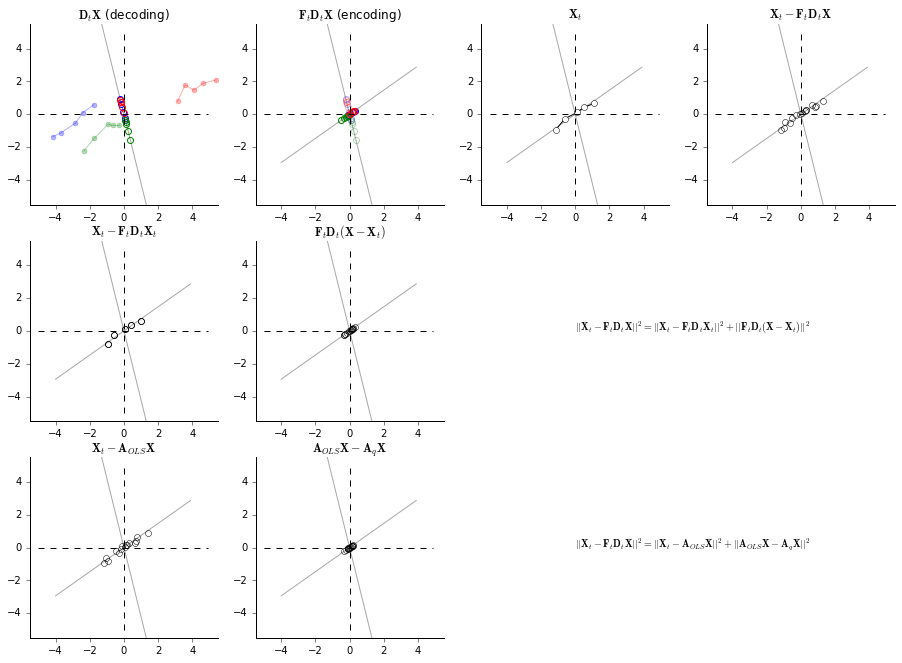

In [5]:
A_OLS = solve(np.dot(X,X.T).T,np.dot(Xt,X.T).T).T
A_OLS_X = np.dot(A_OLS,X)
U, s, V = svd(np.dot(A_OLS_X,A_OLS_X.T))
F = U[:,0]
F = F/norm(F)
D = np.dot(U[:,0],A_OLS)
D = D/norm(D)

x = np.arange(-4,4,0.1)
yd = D[1]/D[0]*x
ye = F[1]/F[0]*x

fig = plt.figure(figsize=(15.5,11))
ax = fig.add_subplot(341)
plt.plot(x,yd,'-',c='#a8a8a8')
DX = np.dot(D[None].T,np.dot(D[None],X))
for ii in range(ns):
    plt.plot(X[0,nt*ii:nt*(ii+1)],X[1,nt*ii:nt*(ii+1)],'.-',color=cv[ii],ms=10,alpha=0.3)
    plt.plot(DX[0,nt*ii:nt*(ii+1)],DX[1,nt*ii:nt*(ii+1)],'o',markeredgecolor=cv[ii],markeredgewidth=1,markerfacecolor='none',ms=6)
plot_commonality(); boxoff(ax)
plt.title('$\mathbf{D}_t \mathbf{X}$ (decoding)');

ax = fig.add_subplot(342)
plt.plot(x,yd,'-',c='#a8a8a8')
plt.plot(x,ye,c='#a8a8a8')
FDX = np.dot(F[None].T,np.dot(F[None],DX))
for ii in range(ns):
    plt.plot(DX[0,nt*ii:nt*(ii+1)],DX[1,nt*ii:nt*(ii+1)],'o',markeredgecolor=cv[ii],markeredgewidth=1,markerfacecolor='none',ms=6,alpha=0.3)
    plt.plot(FDX[0,nt*ii:nt*(ii+1)],FDX[1,nt*ii:nt*(ii+1)],'o',markeredgecolor=cv[ii],markeredgewidth=1,markerfacecolor='none',ms=6)
plot_commonality(); boxoff(ax)
plt.title('$\mathbf{F}_t \mathbf{D}_t \mathbf{X}$ (encoding)');

ax = fig.add_subplot(343)
plt.plot(x,yd,'-',c='#a8a8a8')
plt.plot(x,ye,c='#a8a8a8')
plt.plot(Xt[0,0:nt],Xt[1,0:nt],'ko-',ms=6,markerfacecolor='w')
plot_commonality(); boxoff(ax)
plt.title('$\mathbf{X}_t$');

ax = fig.add_subplot(344)
plt.plot(x,yd,'-',c='#a8a8a8')
plt.plot(x,ye,c='#a8a8a8')
diff = Xt - FDX
plt.plot(diff[0,:],diff[1,:],'ko',ms=6,markerfacecolor='none')
plot_commonality(); boxoff(ax)
plt.title('$\mathbf{X}_t - \mathbf{F}_t \mathbf{D}_t \mathbf{X}$');

ax = fig.add_subplot(345)
plt.plot(x,yd,'-',c='#a8a8a8')
plt.plot(x,ye,c='#a8a8a8')
DXt = np.dot(D[None].T,np.dot(D[None],Xt))
FDXt = np.dot(F[None].T,np.dot(F[None],DXt))
diff = Xt - FDXt
plt.plot(diff[0,:],diff[1,:],'ko',ms=6,markerfacecolor='none')
plot_commonality(); boxoff(ax)
plt.title('$\mathbf{X}_t - \mathbf{F}_t \mathbf{D}_t \mathbf{X}_t$');

ax = fig.add_subplot(346)
plt.plot(x,yd,'-',c='#a8a8a8')
plt.plot(x,ye,c='#a8a8a8')
DXtc = np.dot(D[None].T,np.dot(D[None],X-Xt))
FDXtc = np.dot(F[None].T,np.dot(F[None],DXtc))
plt.plot(FDXtc[0,:],FDXtc[1,:],'ko',ms=6,markerfacecolor='none')
plot_commonality(); boxoff(ax)
plt.title('$\mathbf{F}_t \mathbf{D}_t (\mathbf{X}-\mathbf{X}_t)$');

ax = fig.add_subplot(347)
ax.text(0.5,0.5,'$||\mathbf{X}_t - \mathbf{F}_t \mathbf{D}_t \mathbf{X} ||^2 = ||\mathbf{X}_t - \mathbf{F}_t \mathbf{D}_t \mathbf{X}_t||^2 + ||\mathbf{F}_t \mathbf{D}_t (\mathbf{X}-\mathbf{X}_t)||^2$')
ax.set_frame_on(False)
ax.xaxis.set_ticks_position('none'); ax.yaxis.set_ticks_position('none') 
ax.axes.xaxis.set_ticklabels([]); ax.axes.yaxis.set_ticklabels([])

ax = fig.add_subplot(349)
plt.plot(x,yd,'-',c='#a8a8a8')
plt.plot(x,ye,c='#a8a8a8')
diff = Xt - A_OLS_X
plt.plot(diff[0,:],diff[1,:],'ko',ms=6,markerfacecolor='none')
plot_commonality(); boxoff(ax)
plt.title('$\mathbf{X}_t - \mathbf{A}_{OLS} \mathbf{X}$');

ax = fig.add_subplot(3,4,10)
plt.plot(x,yd,'-',c='#a8a8a8')
plt.plot(x,ye,c='#a8a8a8')
diff = A_OLS_X - FDX
plt.plot(diff[0,:],diff[1,:],'ko',ms=6,markerfacecolor='none')
plot_commonality(); boxoff(ax)
plt.title('$\mathbf{A}_{OLS} \mathbf{X} - \mathbf{A}_q \mathbf{X}$');

ax = fig.add_subplot(3,4,11)
ax.text(0.5,0.5,'$||\mathbf{X}_t - \mathbf{F}_t \mathbf{D}_t \mathbf{X} ||^2 = ||\mathbf{X}_t - \mathbf{A}_{OLS} \mathbf{X}||^2 + ||\mathbf{A}_{OLS} \mathbf{X} - \mathbf{A}_q \mathbf{X}||^2$')
ax.set_frame_on(False)
ax.xaxis.set_ticks_position('none'); ax.yaxis.set_ticks_position('none')
ax.axes.xaxis.set_ticklabels([]); ax.axes.yaxis.set_ticklabels([]);

The data reconstructed by a sequence of decoding and encoding steps, $\mathbf{F}_t\mathbf{D}_t\mathbf{X}$, is aligned along the same direction of $\mathbf{X}_t$ but could not capture entire variance in $\mathbf{X}_t$ (row 1). Given the encoder axis (gray line in NE/SW direction) well-matched to $\mathbf{X}_t$ in terms of the orientation, it is difficult to imagine any linear axis where $\mathbf{X}$ projected onto the line is projected again onto the encoder axis so that the output overlaps $\mathbf{X}_t$ well enough.

It suggests that the error displayed in $\mathbf{X}_t - \mathbf{F}_t \mathbf{D}_t \mathbf{X}$ may come from the limited power of $\textbf{linear}$ dimensionality reduction. To examine the hypothesis, the source of errors are shown in two ways (rows 2-3) as discussed in sections 2-3. We can see most of the errors come from large values of the first term, which was called the non-explained variance in $\mathbf{X}_t$ $(=\mathbf{X}_t - \mathbf{F}_t \mathbf{D}_t \mathbf{X})$ or linear regression error $(\mathbf{X}_t - \mathbf{A}_{OLS} \mathbf{X})$ rather than the variance coming from all the other marginalizations and from trial-to-trial noise $(\mathbf{F}_t \mathbf{D}_t (\mathbf{X}-\mathbf{X}_t))$ or rank constraint on the matrix of regression coefficients $(\mathbf{A}_{OLS} \mathbf{X} - \mathbf{A}_q \mathbf{X})$.

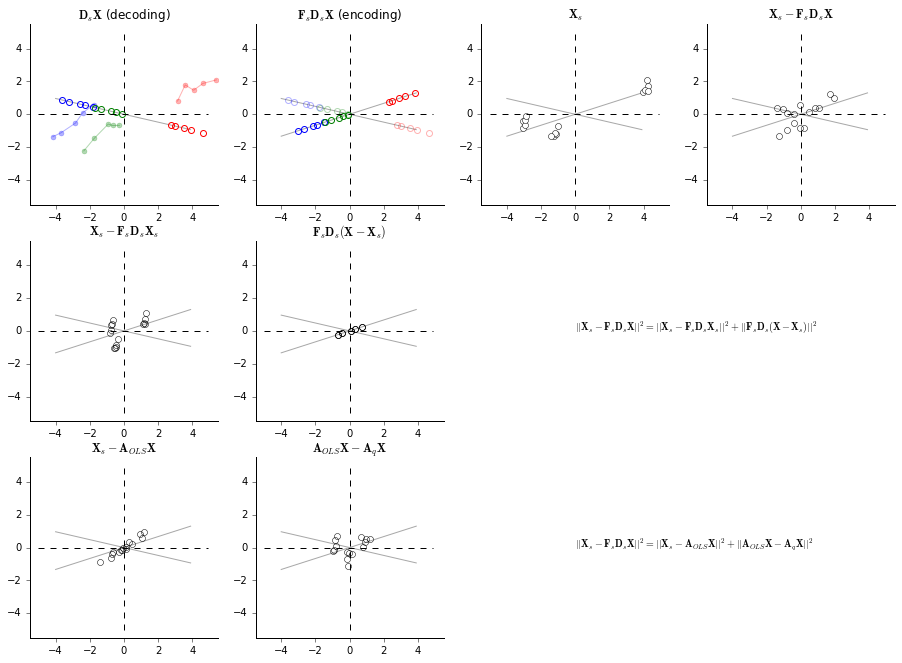

In [6]:
A_OLS = solve(np.dot(X,X.T).T,np.dot(Xs,X.T).T).T
A_OLS_X = np.dot(A_OLS,X)
U, s, V = svd(np.dot(A_OLS_X,A_OLS_X.T))
F = U[:,0]
F = F/norm(F)
D = np.dot(U[:,0],A_OLS)
D = D/norm(D)

x = np.arange(-4,4,0.1)
yd = D[1]/D[0]*x
ye = F[1]/F[0]*x

fig = plt.figure(figsize=(15.5,11))
ax = fig.add_subplot(341)
plt.plot(x,yd,'-',c='#a8a8a8')
DX = np.dot(D[None].T,np.dot(D[None],X))
for ii in range(ns):
    plt.plot(X[0,nt*ii:nt*(ii+1)],X[1,nt*ii:nt*(ii+1)],'.-',color=cv[ii],ms=10,alpha=0.3)
    plt.plot(DX[0,nt*ii:nt*(ii+1)],DX[1,nt*ii:nt*(ii+1)],'o',markeredgecolor=cv[ii],markeredgewidth=1,markerfacecolor='none',ms=6)
plot_commonality(); boxoff(ax)
plt.title('$\mathbf{D}_s \mathbf{X}$ (decoding)');

ax = fig.add_subplot(342)
plt.plot(x,yd,'-',c='#a8a8a8')
plt.plot(x,ye,c='#a8a8a8')
FDX = np.dot(F[None].T,np.dot(F[None],DX))
for ii in range(ns):
    plt.plot(DX[0,nt*ii:nt*(ii+1)],DX[1,nt*ii:nt*(ii+1)],'o',markeredgecolor=cv[ii],markeredgewidth=1,markerfacecolor='none',ms=6,alpha=0.3)
    plt.plot(FDX[0,nt*ii:nt*(ii+1)],FDX[1,nt*ii:nt*(ii+1)],'o',markeredgecolor=cv[ii],markeredgewidth=1,markerfacecolor='none',ms=6)
plot_commonality(); boxoff(ax)
plt.title('$\mathbf{F}_s \mathbf{D}_s \mathbf{X}$ (encoding)');

ax = fig.add_subplot(343)
plt.plot(x,yd,'-',c='#a8a8a8')
plt.plot(x,ye,c='#a8a8a8')
plt.plot(Xs[0,:],Xs[1,:],'ko',ms=6,markerfacecolor='w')
plot_commonality(); boxoff(ax)
plt.title('$\mathbf{X}_s$');

ax = fig.add_subplot(344)
plt.plot(x,yd,'-',c='#a8a8a8')
plt.plot(x,ye,c='#a8a8a8')
diff = Xs - FDX
plt.plot(diff[0,:],diff[1,:],'ko',ms=6,markerfacecolor='none')
plot_commonality(); boxoff(ax)
plt.title('$\mathbf{X}_s - \mathbf{F}_s \mathbf{D}_s \mathbf{X}$');

ax = fig.add_subplot(345)
plt.plot(x,yd,'-',c='#a8a8a8')
plt.plot(x,ye,c='#a8a8a8')
DXs = np.dot(D[None].T,np.dot(D[None],Xs))
FDXs = np.dot(F[None].T,np.dot(F[None],DXs))
diff = Xs - FDXs
plt.plot(diff[0,:],diff[1,:],'ko',ms=6,markerfacecolor='none')
plot_commonality(); boxoff(ax)
plt.title('$\mathbf{X}_s - \mathbf{F}_s \mathbf{D}_s \mathbf{X}_s$');

ax = fig.add_subplot(346)
plt.plot(x,yd,'-',c='#a8a8a8')
plt.plot(x,ye,c='#a8a8a8')
DXsc = np.dot(D[None].T,np.dot(D[None],X-Xs))
FDXsc = np.dot(F[None].T,np.dot(F[None],DXsc))
plt.plot(FDXsc[0,:],FDXsc[1,:],'ko',ms=6,markerfacecolor='none')
plot_commonality(); boxoff(ax)
plt.title('$\mathbf{F}_s \mathbf{D}_s (\mathbf{X}-\mathbf{X}_s)$');

ax = fig.add_subplot(347)
ax.text(0.5,0.5,'$||\mathbf{X}_s - \mathbf{F}_s \mathbf{D}_s \mathbf{X} ||^2 = ||\mathbf{X}_s - \mathbf{F}_s \mathbf{D}_s \mathbf{X}_s||^2 + ||\mathbf{F}_s \mathbf{D}_s (\mathbf{X}-\mathbf{X}_s)||^2$')
ax.set_frame_on(False)
ax.xaxis.set_ticks_position('none'); ax.yaxis.set_ticks_position('none') 
ax.axes.xaxis.set_ticklabels([]); ax.axes.yaxis.set_ticklabels([])

ax = fig.add_subplot(349)
plt.plot(x,yd,'-',c='#a8a8a8')
plt.plot(x,ye,c='#a8a8a8')
diff = Xs - A_OLS_X
plt.plot(diff[0,:],diff[1,:],'ko',ms=6,markerfacecolor='none')
plot_commonality(); boxoff(ax)
plt.title('$\mathbf{X}_s - \mathbf{A}_{OLS} \mathbf{X}$');

ax = fig.add_subplot(3,4,10)
plt.plot(x,yd,'-',c='#a8a8a8')
plt.plot(x,ye,c='#a8a8a8')
diff = A_OLS_X - FDX
plt.plot(diff[0,:],diff[1,:],'ko',ms=6,markerfacecolor='none')
plot_commonality(); boxoff(ax)
plt.title('$\mathbf{A}_{OLS} \mathbf{X} - \mathbf{A}_q \mathbf{X}$');

ax = fig.add_subplot(3,4,11)
ax.text(0.5,0.5,'$||\mathbf{X}_s - \mathbf{F}_s \mathbf{D}_s \mathbf{X} ||^2 = ||\mathbf{X}_s - \mathbf{A}_{OLS} \mathbf{X}||^2 + ||\mathbf{A}_{OLS} \mathbf{X} - \mathbf{A}_q \mathbf{X}||^2$')
ax.set_frame_on(False)
ax.xaxis.set_ticks_position('none'); ax.yaxis.set_ticks_position('none')
ax.axes.xaxis.set_ticklabels([]); ax.axes.yaxis.set_ticklabels([]);

The same results from the average stimulus-varying firing rates $\mathbf{X}_s$. Significant errors are likely to come from the fundamental gap between stimulus class means and the linear encoder axis.

[1] D Kobak+, W Brendel+, C Constantinidis, CE Feierstein, A Kepecs, ZF Mainen, X-L Qi, R Romo, N Uchida, CK Machens
$\textbf{Demixed principal component analysis of neural population data}$
eLife 2016, https://elifesciences.org/content/5/e10989